# Import Dataset and Libraries

In [7]:
# Standarc library imports
from collections import defaultdict
from random import randrange
from tqdm import tqdm
from typing import Any
import warnings

# Third-party imports
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif_func
from umap import UMAP

# Scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.metrics import (
    confusion_matrix, hamming_loss, jaccard_score,
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, OneHotEncoder, OrdinalEncoder, StandardScaler

# Const
DO_OPTIMIZATION = False
RANDOM_STATE = 42
TEST_SIZE = 0.2
ROYALBLUE = "#4169E1"

In [3]:
warnings.filterwarnings(action='ignore')    # 주피터 노트북 에러 로그 무시하는 코드
plt.rc('font', family='Malgun Gothic')      # plt로 한글 폰트 사용하는 코드
# pd.set_option('display.max_rows', None)     # 데이터프레임의 모든 행을 출력하는 코드
pd.set_option('display.max_columns', None)  # 데이터프레임의 모든 열을 출력하는 코드

In [4]:
STD_PATH = "."
TRAIN_FILE = f"{STD_PATH}/train.csv"
TEST_FILE = f"{STD_PATH}/test.csv"

df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

is_pregnant = df_train.columns[-1]
X, y = df_train.drop(is_pregnant, axis=1), df_train[is_pregnant]
X_test = df_test.drop(is_pregnant, axis=1) if is_pregnant in df_test else df_test.copy()

# EDA

In [759]:
def draw_imbalance_barplot(df: pd.DataFrame, title: str, width: int=10, height: int=2) -> None:
    df[title].value_counts().plot.bar(
        color='royalblue',
        figsize = (width, height),
    )    
    plt.title(title)
    plt.xlabel(f"{title} 컬럼의 데이터 종류")
    plt.ylabel('데이터 개수')
    plt.grid(True, linestyle='--', linewidth=0.3, axis='y')
    return

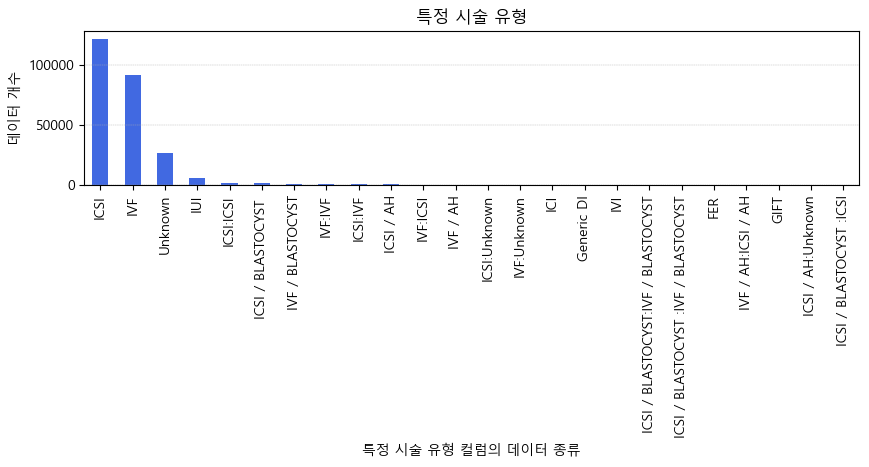

In [760]:
# 테스트용 그래프 그리기(무작위 컬럼)
random_column = X.columns.tolist()[randrange(1, len(X.columns.tolist()))]
draw_imbalance_barplot(X, random_column)

In [761]:
def draw_heatmap(df: pd.DataFrame, method: str='pearson', width: int=8, height: int=8) -> None:
    # method: pearson(default), kendall, spearman
    # interpolation: None(default), nearest, bilinear, bicubic, gaussian, hanning, hamming, lanczos, none
    
    corr_matrix = df.corr(method=method)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))    
    plt.figure(figsize=(width, height))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
    return

In [790]:
# # 테스트용 그래프 그리기
# draw_heatmap(X[infertility_columns], width=5, height=5)

In [763]:
# 범주형 변수이되, 범주 정보가 0: False, 1: True인 column들
categorical_int64_columns = [
    '단일 배아 이식 여부',
    '착상 전 유전 검사 사용 여부',
    '착상 전 유전 진단 사용 여부',
    '동결 배아 사용 여부',
    '신선 배아 사용 여부',
    '기증 배아 사용 여부',
    '대리모 여부',
    'PGD 시술 여부',
    'PGS 시술 여부',
    '배란 자극 여부',
    '남성 주 불임 원인',
    '남성 부 불임 원인',
    '여성 주 불임 원인',
    '여성 부 불임 원인',
    '부부 주 불임 원인',
    '부부 부 불임 원인',
    '불명확 불임 원인',
    '불임 원인 - 난관 질환',
    '불임 원인 - 남성 요인',
    '불임 원인 - 배란 장애',
    '불임 원인 - 여성 요인',
    '불임 원인 - 자궁경부 문제',
    '불임 원인 - 자궁내막증',
    '불임 원인 - 정자 농도',
    '불임 원인 - 정자 면역학적 요인',
    '불임 원인 - 정자 운동성',
    '불임 원인 - 정자 형태'    
]

In [764]:
float64_columns = list(set(X.select_dtypes(include='float64').columns.tolist()) - set(categorical_int64_columns))
# int64_columns = X.select_dtypes(include='int64').columns.tolist()
object_columns = X.select_dtypes(include='O').columns.tolist()

# Data Preprocessing

### 1. Feature Cleaning

In [765]:
# """
# - Missing values(drop, mean, median, mode, KNNImputer, MICE)
# - Outliers (IQR, log)
# - Feature selection(remove duplicates, VIF)
# """

In [766]:
values = {
    **{column: 0 for column in float64_columns},
    **{column: 0 for column in categorical_int64_columns},
    # **{column: "0" for column in object_columns}
}

X.fillna(value=values, inplace=True)
X_test.fillna(value=values, inplace=True)

#### Feature Cleaning - 시술 시기코드(1) 

In [723]:
# 시기 코드는 ID처럼 구분을 위한 컬럼이라고 판단, drop하기로 결정

#### Feature Cleaning - 배란 유도 유형(7)

In [724]:
# X['배란 유도 유형'].value_counts().tolist()
# X_test['배란 유도 유형'].value_counts().tolist()
# value_counts() 결과, train과 test를 통틀어서 유의미한 데이터는 단 2건, 따라서 drop하기로 결정

### 2. Feature Engineering

In [725]:
# """
# - Feature Creation
# - Feature Transformation(log, sqrt, min-max scaling)
# - Feature Extraction(PCA, LDA, heatmap)
# """

#### Feature Engineering - 임신 시도 또는 마지막 임신 경과 연수(3)

In [726]:
# float64 컬럼

#### Feature Engineering - 총 시술 횟수(29) ~ DI 출산 횟수(38)

In [727]:
# 이진 분류기의 최종 목표는 '임신 성공 여부'이기에, 출산 횟수는 전부 drop한다.
# 또한 IVF와 DI의 차이보다는 총 횟수에 중점을 두어 계산한다. (plot().bar()로 분포 차이를 보았을 때 무의미하다 판단)
# 따라서 최종 사용하는 컬럼은 '총 시술 횟수'와 '총 임신 횟수' 2개다.
# 이떄 '총 임신 횟수' / '총 시술 횟수'로 '시술 대비 임신 성공률' 컬럼을 파생 변수로 사용한다.

# 주의할 점은 np.nan와 0의 차이이다.
# 총 시술 횟수가 0인 경우, 0으로 나눌 수 없기에(시술 횟수 자체가 0이기에) np.nan이 나온다.
# 하지만 총 임신 횟수만 0인 경우(시술은 했지만 임신하지 못 한 경우), NaN이 아니라 0이 나온다.
# 둘 다 '실패'로 간주하여 0으로 처리한다. 더 나은 방법이 있다면 차후 변경
def get_int(data: str) -> int:
    return int(data[0])

X['총 임신 횟수'] = X['총 임신 횟수'].map(get_int)
X['총 시술 횟수'] = X['총 시술 횟수'].map(get_int)
X_pregnancy = rate = X['총 임신 횟수'] / X['총 시술 횟수']
X['시술 대비 임신 성공률'] = X_pregnancy.fillna(0.0)

X_test['총 임신 횟수'] = X_test['총 임신 횟수'].map(get_int)
X_test['총 시술 횟수'] = X_test['총 시술 횟수'].map(get_int)
X_test_pregnancy = rate = X_test['총 임신 횟수'] / X_test['총 시술 횟수']
X_test['시술 대비 임신 성공률'] = X_test_pregnancy.fillna(0.0)

#### Feature Engineering - 총 생성 배아 수(39) ~ 기증자 정자와 혼합된 난자 수(52) 

In [728]:
# float64 컬럼

#### Feature Engineering - 난자 채취 경과일(63) ~ 배아 해동 경과일(67)

In [729]:
# float64 컬럼

#### Featrue Engineering - 남성 주 불임 원인(11) ~ 부부 부 불임 원인(16)

In [785]:
# 인자 분석의 설명 및 예시(증명과 상세 rotation 포함)
# https://zephyrus1111.tistory.com/465

infertility_columns = [
    '남성 주 불임 원인', '남성 부 불임 원인',
    '여성 주 불임 원인', '여성 부 불임 원인',
    '부부 주 불임 원인', '부부 부 불임 원인'
]
df_selected = X[infertility_columns]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_selected)

dimension = 2
fa = FactorAnalysis(n_components=dimension)
fa_result = fa.fit_transform(scaled_data)

factor_loadings = pd.DataFrame(fa.components_.T, index=df_selected.columns, columns=['Factor1', 'Factor2'])
factor_loadings

,Factor1,Factor2
남성 주 불임 원인,0.914637,-0.052408
남성 부 불임 원인,0.197939,0.844748
여성 주 불임 원인,0.893289,0.011166
여성 부 불임 원인,0.195515,0.776927
부부 주 불임 원인,0.999530,-0.000679
부부 부 불임 원인,-0.014867,0.944255


#### Feature Engineering - Categorical int64 columns

In [731]:
# 배란 자극 여부(6), 단일 배아 이식 여부(8) ~ 불임 원인 - 정자 형태(27), 동결 배아 사용 여부(57) ~ PGS 시술 여부(62)

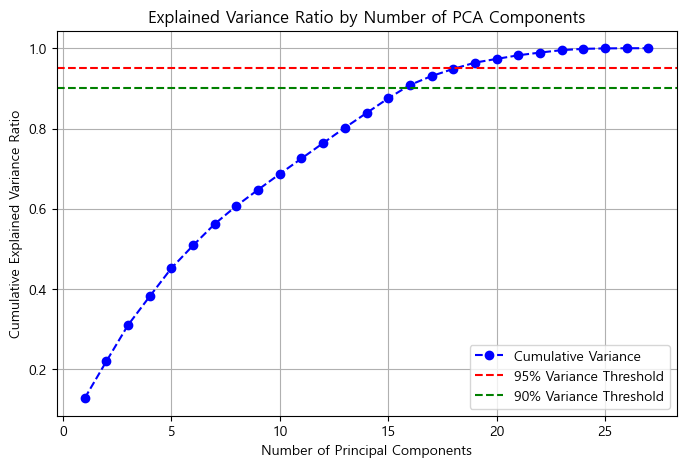

16

In [767]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X[categorical_int64_columns])
pca_full = PCA().fit(scaled_data)

# 누적 설명 분산 비율 계산
explained_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)

# 가장 적절한 주성분 개수 확인 (90% 이상의 설명력을 가지는 최소 주성분 개수)
optimal_components = np.argmax(explained_variance_ratio >= 0.90) + 1

# 시각화를 통해 몇 개의 주성분이 적절한지 확인
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='b', label="Cumulative Variance")
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Variance Threshold')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Variance Ratio by Number of PCA Components")
plt.legend()
plt.grid()
plt.show()

# 최적의 주성분 개수 출력
optimal_components

In [770]:
# 범주 정보가 0: False, 1: True인 column들 bool으로 타입 변환
scaled_data = scaler.fit_transform(X[categorical_int64_columns])

dimension = optimal_components
umap_model = UMAP(
    n_components=dimension,
    n_neighbors=5,
    min_dist=0.1,
    n_epochs=200,
    metric='cosine',
    low_memory=True,
    random_state=RANDOM_STATE
)
umap_result = umap_model.fit_transform(scaled_data)
umap_df = pd.DataFrame(umap_result, columns=[f"UMAP{i+1}" for i in range(optimal_components)])
umap_df.head()

,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAP10,UMAP11,UMAP12,UMAP13,UMAP14,UMAP15,UMAP16
0,2.867214,2.983788,5.042185,4.484770,10.165933,10.934456,2.251791,1.259081,6.337331,2.768757,3.059429,3.533575,2.070020,2.945693,4.309107,1.353196
1,5.504967,5.538579,3.110630,5.404008,4.951099,-1.486667,4.038643,5.494677,11.782536,1.651493,2.935050,4.071842,1.965274,3.004070,4.517408,1.284422
2,-0.132947,2.033978,2.555112,2.888336,3.187675,4.393469,4.748248,3.473041,5.324028,3.059656,2.933026,3.217143,2.610753,2.900119,3.217237,1.807198
3,0.438547,1.468002,2.477978,2.084705,3.496666,4.827696,3.816955,3.153088,4.729001,3.323163,3.225796,5.132599,2.462660,3.473151,4.140796,1.850458
4,5.348098,5.329204,5.248363,9.569267,1.417292,7.636187,10.043842,0.159362,5.203619,3.008459,2.475838,3.713395,1.649536,2.848469,4.720578,1.310438


In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_df['UMAP1'], y=umap_df['UMAP2'], alpha=0.7)
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("UMAP Projection of Infertility Causes")
plt.show()

### 3. Feature Encoding

In [771]:
# """
# - LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
# """

#### Feature Encoding - 시술 당시 나이(2)

In [772]:
# '알 수 없음' 데이터는 최빈값으로 처리
X['시술 당시 나이'] = X['시술 당시 나이'].replace('알 수 없음', np.nan)
X['시술 당시 나이'].fillna(X['시술 당시 나이'].mode()[0], inplace=True)
X_test['시술 당시 나이'] = X_test['시술 당시 나이'].replace('알 수 없음', np.nan)
X_test['시술 당시 나이'].fillna(X_test['시술 당시 나이'].mode()[0], inplace=True)

# OrdinalEncoder 사용을 위해 나이 순서대로 order 준비
custom_order = [sorted(X['시술 당시 나이'].value_counts().index.tolist())]
encoder = OrdinalEncoder(categories=custom_order)

# 나이(순서)를 반영하여 encoding 진행
X['시술 당시 나이'] = encoder.fit_transform(X[['시술 당시 나이']])
X_test['시술 당시 나이'] = encoder.fit_transform(X_test[['시술 당시 나이']])

#### Feature Encoding - 시술 유형(4)

In [773]:
# 시술 유형은 2가지(IVF와 DI)로 VIF 추론이 가능하므로 drop_first함
encoder = OneHotEncoder(drop='first', sparse_output=False)

# 2가지 데이터에 대해 처리했으므로 True와 False로 취급할 수 있다고 판단하였다.
# 따라서, 메모리 개선을 위해 ohe로 transform한 값을 bool로 바꿔주었다.
X['시술 유형'] = encoder.fit_transform(X[['시술 유형']]).astype(int)
X_test['시술 유형'] = encoder.fit_transform(X_test[['시술 유형']]).astype(int)

#### Feature Encoding - 특정 시술 유형(5)

In [774]:
# Feature Cleaning
X['특정 시술 유형'].fillna('0', inplace=True)
X_test['특정 시술 유형'].fillna('0', inplace=True)

# 복합 요소 떄문에 Multi-Label 인코딩을 진행
classes = ['IVF', 'ICSI', 'IUI', 'ICI', 'GIFT', 'FER', 'Generic DI', 'IVI', 'BLASTOCYST', 'AH', 'Unknown']
mlb = MultiLabelBinarizer(classes=classes)

# 정규화를 위한 정규표현식 dictionary
replace_dict = {':': '/', ' ': '', '0': 'Unknown'}

# 데이터 정규화
X['특정 시술 유형'] = X['특정 시술 유형'].replace(replace_dict, regex=True).str.split('/')
X_test['특정 시술 유형'] = X_test['특정 시술 유형'].replace(replace_dict, regex=True).str.split('/')

# Multi-Label Encoding 진행 후 데이터프레임 병합
X_encoded = mlb.fit_transform(X['특정 시술 유형'])
X = pd.concat([X, pd.DataFrame(X_encoded, columns=mlb.classes_)], axis=1)
X.drop(['Unknown'], axis=1, inplace=True)

X_test_encoded = mlb.fit_transform(X_test['특정 시술 유형'])
X_test = pd.concat([X_test, pd.DataFrame(X_test_encoded, columns=mlb.classes_)], axis=1)
X_test.drop(['Unknown'], axis=1, inplace=True)

In [775]:
# 데이터 drop에 사용할 column 이름 변수
시술_유형_mlb_columns = mlb.classes_.tolist()

#### Feature Encoding - 배아 생성 주요 이유(28)

In [776]:
# Feature Cleaning
X['배아 생성 주요 이유'].fillna('', inplace=True)
X_test['배아 생성 주요 이유'].fillna('', inplace=True)

# 복합 요소 떄문에 Multi-Label 인코딩을 진행
classes = ['기증용', '난자 저장용', '배아 저장용', '연구용', '현재 시술용']
mlb = MultiLabelBinarizer(classes=classes)

# 정규화를 위한 정규표현식 dictionary
replace_dict = {' ': ''}

# 데이터 정규화
X['배아 생성 주요 이유'] = X['배아 생성 주요 이유'].replace(replace_dict, regex=True).str.split(',')
X_test['배아 생성 주요 이유'] = X_test['배아 생성 주요 이유'].replace(replace_dict, regex=True).str.split(',')

# Multi-Label Encoding 진행 후 데이터프레임 병합
X_encoded = mlb.fit_transform(X['배아 생성 주요 이유'])
X = pd.concat([X, pd.DataFrame(X_encoded, columns=mlb.classes_)], axis=1)
X_test_encoded = mlb.fit_transform(X_test['배아 생성 주요 이유'])
X_test = pd.concat([X_test, pd.DataFrame(X_test_encoded, columns=mlb.classes_)], axis=1)

In [777]:
# 데이터 drop에 사용할 column 이름 변수
배아_생성_주요_이유_mlb_columns = mlb.classes_[1:]

#### Feature Encoding - 난자 출처(53)

In [778]:
# 난자 출처는 3가지 값(본인 제공, 기증 제공, 알 수 없음)만을 가지고 있다.
# 순서가 존재하는 것도 아니고 column이 극단적으로 늘어나는 경우도 아니기에 OneHotEncoding(get_dummies)을 진행
# 본인 제공 0, 기증 제공 0인 경우에는 자연스럽게 알 수 없는 경우가 된다.
# 따라서 '알 수 없음' column을 제거하면, VIF를 없앨 수 있다.
X_난자_출처 = pd.get_dummies(X, columns=['난자 출처'], dtype='int64')[['난자 출처_본인 제공', '난자 출처_기증 제공']]
X = pd.concat([X, X_난자_출처], axis=1)
X_test_난자_출처 = pd.get_dummies(X_test, columns=['난자 출처'], dtype='int64')[['난자 출처_본인 제공', '난자 출처_기증 제공']]
X_test = pd.concat([X_test, X_test_난자_출처], axis=1)

#### Feature Encoding - 정자 출처(54)

In [779]:
# 정자 출처는 4가지 값(배우자 제공, 기증 제공, 미할당, 배우자 및 기증 제공)을 가지고 있다.
# '배우자 제공'과 '기증 제공'을 기준으로 Multi-Label Encoding 진행.
mlb = MultiLabelBinarizer()


# 정규화를 위한 func
def replace_semen_source(data: str) -> list:
    if '및' in data:
        return ['정자 출처_배우자 제공', '정자 출처_기증 제공']
    elif '배우자' in data:
        return ['정자 출처_배우자 제공']
    elif '기증' in data:
        return ['정자 출처_기증 제공']
    else:
        return []


# Data Cleaning
X.fillna(X['정자 출처'].mode()[0], inplace=True)
X_test.fillna(X_test['정자 출처'].mode()[0], inplace=True)

# 데이터 정규화
X['정자 출처'] = X['정자 출처'].map(replace_semen_source)
X_test['정자 출처'] = X_test['정자 출처'].map(replace_semen_source)

# Multi-Label Encoding 진행 후 데이터프레임 병합
X_encoded = mlb.fit_transform(X['정자 출처'])
X = pd.concat([X, pd.DataFrame(X_encoded, columns=mlb.classes_)], axis=1)
X_test_encoded = mlb.fit_transform(X_test['정자 출처'])
X_test = pd.concat([X_test, pd.DataFrame(X_test_encoded, columns=mlb.classes_)], axis=1)

In [780]:
# 데이터 drop에 사용할 column 이름 변수
정자_출처_mlb_columns = mlb.classes_.tolist()

#### Feature Encoding - 난자 기증자 나이(55), 정자 기증자 나이(56)

In [781]:
# OrdinalEncodeing 방식을 위해 나이 순서대로 order 준비
custom_order = ['알 수 없음', '만20세 이하', '만21-25세', '만26-30세', '만31-35세', '만36-40세', '만41-45세']

# 나이(순서)를 반영하여 encoding 진행
X['난자 기증자 나이'] = X['난자 기증자 나이'].apply(lambda x: custom_order.index(x))
X['정자 기증자 나이'] = X['정자 기증자 나이'].apply(lambda x: custom_order.index(x))
X_test['난자 기증자 나이'] = X_test['난자 기증자 나이'].apply(lambda x: custom_order.index(x))
X_test['정자 기증자 나이'] = X_test['정자 기증자 나이'].apply(lambda x: custom_order.index(x))

### 4. Feature Removal

In [782]:
# 주석이 달린 컬럼만 모델 학습에 사용
drop_features = [
     'ID',
     '시술 시기 코드',
    #  '시술 당시 나이',
    #  '임신 시도 또는 마지막 임신 경과 연수',
    #  '시술 유형',
     '특정 시술 유형',
    #  '배란 자극 여부',
     '배란 유도 유형',
    #  '단일 배아 이식 여부',
    #  '착상 전 유전 검사 사용 여부',
    #  '착상 전 유전 진단 사용 여부',
    #  '남성 주 불임 원인',
    #  '남성 부 불임 원인',
    #  '여성 주 불임 원인',
    #  '여성 부 불임 원인',
    #  '부부 주 불임 원인',
    #  '부부 부 불임 원인',
    #  '불명확 불임 원인',
    #  '불임 원인 - 난관 질환',
    #  '불임 원인 - 남성 요인',
    #  '불임 원인 - 배란 장애',
    #  '불임 원인 - 여성 요인',
    #  '불임 원인 - 자궁경부 문제',
    #  '불임 원인 - 자궁내막증',
    #  '불임 원인 - 정자 농도',
    #  '불임 원인 - 정자 면역학적 요인',
    #  '불임 원인 - 정자 운동성',
    #  '불임 원인 - 정자 형태',
     '배아 생성 주요 이유',
    #  '총 시술 횟수',
     '클리닉 내 총 시술 횟수',
     'IVF 시술 횟수',
     'DI 시술 횟수',
    #  '총 임신 횟수',
     'IVF 임신 횟수',
     'DI 임신 횟수',
     '총 출산 횟수',
     'IVF 출산 횟수',
     'DI 출산 횟수',
    #  '총 생성 배아 수',
    #  '미세주입된 난자 수',
    #  '미세주입에서 생성된 배아 수',
    #  '이식된 배아 수',
    #  '미세주입 배아 이식 수',
    #  '저장된 배아 수',
    #  '미세주입 후 저장된 배아 수',
    #  '해동된 배아 수',
    #  '해동 난자 수',
    #  '수집된 신선 난자 수',
    #  '저장된 신선 난자 수',
    #  '혼합된 난자 수',
    #  '파트너 정자와 혼합된 난자 수',
    #  '기증자 정자와 혼합된 난자 수',
     '난자 출처',
     '정자 출처',
    #  '난자 기증자 나이',
    #  '정자 기증자 나이',
    #  '동결 배아 사용 여부',
    #  '신선 배아 사용 여부',
    #  '기증 배아 사용 여부',
    #  '대리모 여부',
    #  'PGD 시술 여부',
    #  'PGS 시술 여부',
    #  '난자 채취 경과일',
    #  '난자 해동 경과일',
    #  '난자 혼합 경과일',
    #  '배아 이식 경과일',
    #  '배아 해동 경과일',
    # '시술 대비 임신 성공률',
    # *시술_유형_mlb_columns,
    # *배아_생성_주요_이유_mlb_columns,
    # '난자 출처_기증 제공',
    # '난자 출처_본인 제공',
    # *정자_출처_mlb_columns,
]

In [783]:
# VIF 계산하는 함수 개선 필요
def calculate_vif(df: pd.DataFrame):
    all_columns = df.columns.tolist()
    vif_columns = list(set(all_columns) - set(drop_features))
    df = df[vif_columns]
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [vif_func(df.values, i) for i in range(df.shape[1])]
    return vif_data.sort_values(by="VIF", ascending=False)

In [784]:
# VIF 계산
vif_result = calculate_vif(X)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
over_10_drop = [
    vif_result.iloc[idx][0]
    for idx in range(len(vif_result))
    if vif_result.iloc[idx][1] >= 10
]
nan_drop = vif_result.loc[vif_result['VIF'].isna(), 'Feature'].tolist()
drop_features = list(set(drop_features) | set(over_10_drop) | set(nan_drop))

In [ ]:
# drop_features

In [ ]:
X = X.drop(drop_features, axis=1)
X_test = X_test.drop(drop_features, axis=1)

# Hyperparameter Tuning

In [700]:
# https://velog.io/@hyunicecream/GridSearchCV%EB%9E%80-%EC%96%B4%EB%96%BB%EA%B2%8C-%EC%82%AC%EC%9A%A9%ED%95%A0%EA%B9%8C

In [701]:
def optimize() -> None:
    return


if DO_OPTIMIZATION:
    optimize()

# Modeling

### 1. Import

In [702]:
# Model imports
from sklearn.base import BaseEstimator
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [703]:
clf_model_dict = {
    "adaboost": AdaBoostClassifier(),
    "gradient": GradientBoostingClassifier(),
    "random_forest": RandomForestClassifier(),
    "lasso": LogisticRegression(penalty='l1', solver='liblinear'),
    "ridge": LogisticRegression(penalty='l2', solver='lbfgs'),
    "svc": SVC(probability=True),
    "decision_tree": DecisionTreeClassifier(),
    "catboost": CatBoostClassifier(verbose=False),
    "lgbm": LGBMClassifier(),
    "xgb": XGBClassifier(),
}

### 2. Training

In [704]:
def evaluate(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> tuple[float]:
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:,1]

    # is CatBoostClassifier
    if isinstance(y_pred[0], str):
        accuracy = accuracy_score(y, y_pred)                        # 정확도
        precision = precision_score(y, y_pred, pos_label='True')    # 정밀도
        recall = recall_score(y, y_pred, pos_label='True')          # 재현율
        f1 = f1_score(y, y_pred, pos_label='True')                  # F1 점수
        roc_auc = roc_auc_score(y, y_proba)                         # ROC-AUC 점수
        
    else:
        accuracy = accuracy_score(y, y_pred)      # 정확도
        precision = precision_score(y, y_pred)    # 정밀도
        recall = recall_score(y, y_pred)          # 재현율
        f1 = f1_score(y, y_pred)                  # F1 점수
        roc_auc = roc_auc_score(y, y_proba)       # ROC-AUC 점수
    
    return accuracy, precision, recall, f1, roc_auc

### 3. Select Model

In [705]:
model_name = "catboost"
model = clf_model_dict[model_name]

### 4. K-Fold Cross Validation

In [706]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
roc_auc_scores = []
score_types = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

for idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[test_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    scores = evaluate(model, X_val, y_val)
    roc_auc_scores.append(scores[-1])

    for score_type, score in zip(score_types, scores):
        print(f"{score_type} (Fold {idx}): {score}")
    print()

print(f"Cross-Validation Average ROC-AUC Score: {np.mean(roc_auc_scores)}")

Accuracy (Fold 0): 0.7434222074857132
Precision (Fold 0): 0.514932720708894
Recall (Fold 0): 0.1184508530877246
F1-Score (Fold 0): 0.19259804824157614
ROC-AUC (Fold 0): 0.7261184029555323

Accuracy (Fold 1): 0.743397698459138
Precision (Fold 1): 0.5150796340223653
Recall (Fold 1): 0.11476028690071725
F1-Score (Fold 1): 0.18770066683131637
ROC-AUC (Fold 1): 0.730646561080571

Accuracy (Fold 2): 0.7437682855471036
Precision (Fold 2): 0.5173745173745173
Recall (Fold 2): 0.12140430351075877
F1-Score (Fold 2): 0.1966611630893414
ROC-AUC (Fold 2): 0.7271225130791295

Accuracy (Fold 3): 0.7433781938755608
Precision (Fold 3): 0.5149278765514927
Recall (Fold 3): 0.11588404046504605
F1-Score (Fold 3): 0.18919085474825906
ROC-AUC (Fold 3): 0.7253717585377786

Accuracy (Fold 4): 0.7435927442949093
Precision (Fold 4): 0.5168804861580013
Recall (Fold 4): 0.11558206250943681
F1-Score (Fold 4): 0.18891905231984205
ROC-AUC (Fold 4): 0.7262463233961535

Cross-Validation Average ROC-AUC Score: 0.72710111

# Visualization

### 1. Using Seaborn

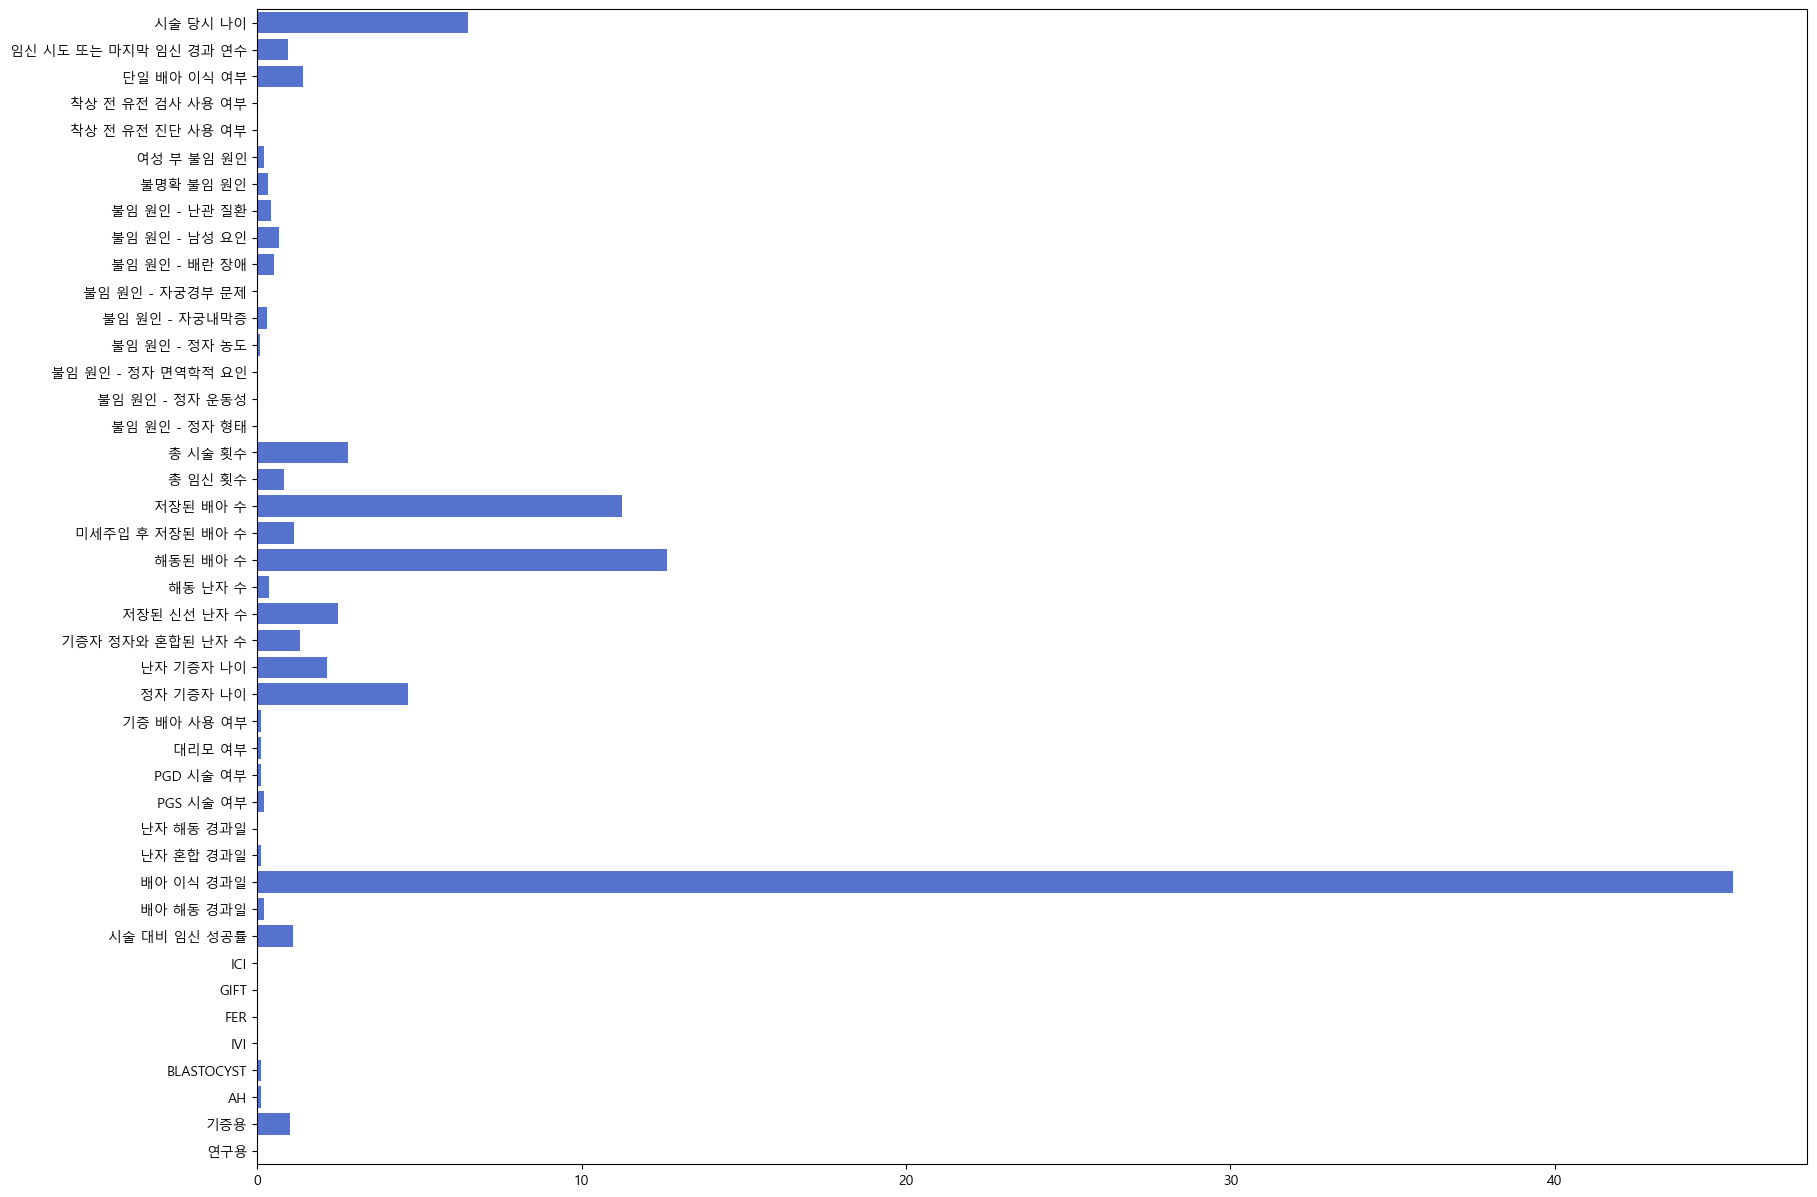

In [707]:
feature_names = X.columns.tolist()
plt.figure(figsize=(20,15))
if isinstance(model, LogisticRegression):
    sns.barplot(x=model.coef_[0], y=feature_names, palette=[ROYALBLUE])
else:
    sns.barplot(x=model.feature_importances_, y=feature_names, palette=[ROYALBLUE])

### 2. DESC Feature Importances

In [708]:
importances = (
    sorted(enumerate(model.coef_[0]), key=lambda x: x[1], reverse=True)[:5]
    if isinstance(model, LogisticRegression)
    else sorted(enumerate(model.feature_importances_), key=lambda x: x[1], reverse=True)[:5]
)

for idx, (col, score) in enumerate(importances, 1):
    print(f"{idx}. {X.columns.tolist()[col]} ({score:.2f})")

1. 배아 이식 경과일 (45.50)
2. 해동된 배아 수 (12.65)
3. 저장된 배아 수 (11.23)
4. 시술 당시 나이 (6.51)
5. 정자 기증자 나이 (4.64)


In [709]:
set(X.columns) - set(X_test.columns)

set()

# Create Submission

In [710]:
# Final Submission
model.fit(X, y)
prediction = model.predict(X_test)
df_submission = pd.DataFrame({'ID': df_test['ID'], 'probability': prediction})
df_submission.to_csv("submission.csv", index=False)
df_submission['probability'].value_counts()

probability
0    84913
1     5154
Name: count, dtype: int64